<a href="https://colab.research.google.com/github/jnsbrdbr/new_thesiis/blob/main/9.9_TUGaussian_Svm_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import copy
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import svm
from sklearn.gaussian_process.kernels import RBF
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from matplotlib import pyplot
from sklearn.metrics import accuracy_score

In [2]:
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip3 install pickle5
import pickle5 as pickle

In [4]:
with open('/content/drive/MyDrive/10000/unsmote/TUnsmote_Tresult.pkl', "rb") as fh:
  result = pickle.load(fh)

In [5]:
print(result)

             0         1         2         3         4          5         6  \
0    -0.018442 -4.220618 -0.916300 -0.715505 -0.868530  -1.348268 -0.474432   
1    -0.018442 -4.220618 -0.916300 -0.715505 -0.868530  -1.348268 -0.474432   
2    -0.018442 -4.220618 -0.916300 -0.715505 -0.868530  -1.348268 -0.474432   
3    -0.018442 -4.220618 -0.916300 -0.715505 -0.868530  -1.348268 -0.474432   
4    -0.018444 -4.221080 -0.916678 -0.715889 -0.869072  -1.349276 -0.475212   
...        ...       ...       ...       ...       ...        ...       ...   
9995 -0.264492 -4.771727 -2.334318 -2.416962 -8.513026  15.729413  0.366719   
9996 -0.264492 -4.771727 -2.334318 -2.416962 -8.513026  15.729413  0.366719   
9997 -0.264492 -4.771727 -2.334318 -2.416962 -8.513026  15.729413  0.366719   
9998 -0.264492 -4.771727 -2.334318 -2.416962 -8.513026  15.729413  0.366719   
9999 -0.264492 -4.771727 -2.334318 -2.416962 -8.513026  15.729413  0.366719   

             7         8         9  ...          1 

In [6]:
#divide data in to data_label and non_data label

y=result.label
pd.options.mode.chained_assignment = None  # default='warn'
for i in range(len(y)):
  if y[i]==1:
    y[i]=0
  else:
    y[i]=1

In [7]:
result_nonlabel=copy.deepcopy(result)
del result_nonlabel['label']
X=result_nonlabel

In [8]:
#splitting data in to test and train...

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3,shuffle=True)

In [9]:
#train the data

k=svm.SVC(kernel="rbf",gamma=50, C=0.01, probability=True)#gamma=0.0001, C=10#gamma=0.1, C=10,
gpc = k.fit(x_train, y_train)
predictions = gpc.predict(x_test)
score = gpc.score(x_test, y_test)
print(score)

0.9913333333333333


Accuracy:  0.9913333333333333




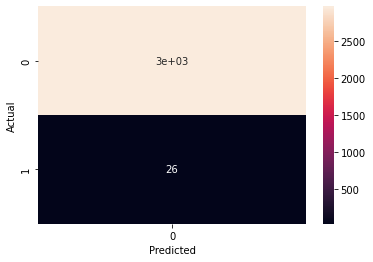

In [10]:
#Accuracy

print('Accuracy: ',metrics.accuracy_score(y_test, predictions))
print('\n')
#plotting confusion_matrix

confusion_matrix = pd.crosstab(y_test, predictions, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)

In [11]:
#cross_validation and accracy

cv = KFold(n_splits=10, shuffle=True)# x_train, y_train, random_state=42
scores = cross_val_score(k,X, y, scoring='accuracy', cv=cv)

print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.991 (0.004)


In [12]:
#recall/TPR

cv = KFold(n_splits=10, shuffle=True)#, random_state=42
scores_recall = cross_val_score(k,X, y, scoring='recall', cv=cv)

print('scores_recall: %.3f (%.3f)' % (mean(scores_recall), std(scores_recall)))

scores_recall: 0.000 (0.000)


In [13]:
#precision
import warnings
warnings.filterwarnings('ignore') 

cv = KFold(n_splits=10, shuffle=True)#, random_state=42
scores_precision = cross_val_score(k, X, y, scoring='precision', cv=cv)

print('scores_precision: %.3f (%.3f)' % (mean(scores_precision), std(scores_precision)))

scores_precision: 0.000 (0.000)


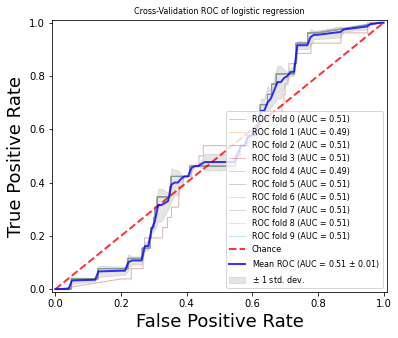

In [14]:
#ROC_AUC

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(6,5))
i = 0
for train, test in cv.split(X, y):
    probas_ = k.fit(x_train, y_train).predict_proba(x_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.title('Cross-Validation ROC of logistic regression',fontsize=8)
plt.legend(loc="lower right", prop={'size': 8})
plt.show()

In [15]:
#FPR
from sklearn.metrics import confusion_matrix

kf = KFold(n_splits=10)#, random_state=None
res_fpr = list()
for train_index , test_index in kf.split(X):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    k.fit(X_train,y_train)
    pred_values = k.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, pred_values, labels=[0, 1]).ravel()
    print(f'True Positives: {tp}')
    print(f'False Positives: {fp}')
    print(f'True Negatives: {tn}')
    print(f'False Negatives: {fn}')
    fpr=(np.divide(fp,(fp+tn)))
    if fp==0:
      fpr=0

    print('fpr=%.3f' % (mean(fpr)))#tpr=%.4f : mean(tpr), 
    res_fpr.append(mean(fpr))
    print('---------------------')

total_fpr=np.sum(res_fpr)/10
print('\n\n','total_fpr=%.3f' % (total_fpr))# total_tpr=%.4f :total_tpr,

True Positives: 0
False Positives: 0
True Negatives: 2975
False Negatives: 25
fpr=0.000
---------------------
True Positives: 0
False Positives: 0
True Negatives: 2972
False Negatives: 28
fpr=0.000
---------------------
True Positives: 0
False Positives: 0
True Negatives: 2970
False Negatives: 30
fpr=0.000
---------------------
True Positives: 0
False Positives: 0
True Negatives: 2975
False Negatives: 25
fpr=0.000
---------------------
True Positives: 0
False Positives: 0
True Negatives: 2969
False Negatives: 31
fpr=0.000
---------------------
True Positives: 0
False Positives: 0
True Negatives: 2976
False Negatives: 24
fpr=0.000
---------------------
True Positives: 0
False Positives: 0
True Negatives: 2974
False Negatives: 26
fpr=0.000
---------------------
True Positives: 0
False Positives: 0
True Negatives: 2974
False Negatives: 26
fpr=0.000
---------------------
True Positives: 0
False Positives: 0
True Negatives: 2977
False Negatives: 23
fpr=0.000
---------------------
True Posit